# Workflow for n-artifact clusters

1. **additional artifacts**: 

(a) completely surrounded by artifacts --> artifacts themselves

(b) contiguous to an artifact (or artifact cluster?) and with an artifact index NEAR the artifact index for that city

2. Identify n-artifact clusters (clusters of contiguous artifacts, n>2); make sure that the union has no interior
3. For each cluster, drop all the interior lines and skeletonize
4. Visualize to see if it works

- number of nodes
- number of continuity groups
- filter non-planarity artifacts
- CES counts
- prime detection
- crosses detection
- touches detecion

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import momepy
import numpy as np
import pandas as pd
import shapely
from libpysal import graph
from scipy import sparse
import folium
import folium.plugins as plugins
import shapely

from core import algorithms, utils
from core.geometry import voronoi_skeleton

Specify case metadata

In [2]:
case = "Liège"

Read road data

In [3]:
roads = utils.read_original(case)

Remove duplicated roads

In [4]:
roads = momepy.remove_false_nodes(roads)
roads = roads[~roads.geometry.duplicated()].reset_index()
roads = momepy.remove_false_nodes(roads)

Assign COINS-based information to roads

In [5]:
# %%time
roads, coins = algorithms.common.continuity(roads)

Read **polygons**

In [6]:
fas = momepy.FaceArtifacts(roads)
polygons = fas.polygons.set_crs(roads.crs)

**Iteratively identify polygons that are fully enclosed by artifacts, or that touch artifacts and have a FAI in +1% of threshold, as artifacts**  

In [7]:
# rook neighbors
rook = graph.Graph.build_contiguity(polygons, rook=True)
polygons["neighbors"] = rook.neighbors
prop = 1.01

# polygons are not artifacts,
polygons["is_artifact"] = False
# unless the fai is below the threshold,
polygons.loc[polygons.face_artifact_index < fas.threshold, "is_artifact"] = True

# OR (iteratively)

while True:
    artifact_count_before = sum(polygons.is_artifact)

    # polygons that are enclosed by artifacts
    polygons["enclosed"] = polygons.apply(
        lambda x: len(x.neighbors) > 0
        and all(polygons.loc[list(x.neighbors), "is_artifact"]),
        axis=1,
    )
    # setting is_artifact to True
    polygons.loc[polygons.enclosed, "is_artifact"] = True

    # polygons that are touching artifacts and within x% of fai
    polygons["touching"] = polygons.apply(
        lambda x: len(x.neighbors) > 0
        and any(polygons.loc[list(x.neighbors), "is_artifact"]),
        axis=1,
    )

    # setting is_artifact to True
    polygons.loc[
        (polygons.touching == True)
        & (polygons.face_artifact_index < fas.threshold * prop),
        "is_artifact",
    ] = True

    artifact_count_after = sum(polygons.is_artifact)
    if artifact_count_after == artifact_count_before:
        break

In [8]:
print(artifact_count_after)

3662


In [9]:
# m = roads.explore(
#     "coins_len",
#     k=20,
#     scheme="quantiles",
#     tiles="cartodb positron",
#     prefer_canvas=True,
#     name="Roads",
#     highlight_kwds={"color": "red"},
#     style_kwds=dict(weight=5),
#     max_zoom=52,
#     opacity=0.5,
# )
# polygons[polygons.is_artifact].explore(m=m, name = "All artifacts", color = "red")
# polygons[polygons.face_artifact_index < fas.threshold].explore(m=m, name = "Initial artifacts", color = "green")
# #nodes.explore(m=m, name="Nodes", color="blue", marker_size=250)
# folium.LayerControl().add_to(m)
# plugins.MousePosition().add_to(m)

# m

**Get artifacts gdf**

In [10]:
artifacts = polygons[polygons.is_artifact][["geometry"]].copy()
artifacts["id"] = artifacts.index
artifacts.head()

geometry  id
0   POLYGON ((687053.642 5615820.989, 687059.393 5...   0
2   POLYGON ((687053.642 5615820.989, 687051.723 5...   2
4   POLYGON ((677400.757 5613704.998, 677429.096 5...   4
7   POLYGON ((682353.554 5612410.841, 682350.603 5...   7
10  POLYGON ((685360.558 5609766.62, 685359.515 56...  10

Remove edges fully within the artifact (dangles).

In [11]:
a_idx, _ = roads.sindex.query(artifacts.geometry, predicate="contains")
artifacts = artifacts.drop(artifacts.index[a_idx])

Get nodes from the network.

In [12]:
nodes = momepy.nx_to_gdf(momepy.node_degree(momepy.gdf_to_nx(roads)), lines=False)

Link nodes to artifacts

In [13]:
node_idx, artifact_idx = artifacts.sindex.query(
    nodes.buffer(0.1), predicate="intersects"
)
intersects = sparse.coo_array(
    ([True] * len(node_idx), (node_idx, artifact_idx)),
    shape=(len(nodes), len(artifacts)),
    dtype=np.bool_,
)

Compute number of nodes per artifact

In [14]:
artifacts["node_count"] = intersects.sum(axis=0)

Apply additional filters to remove artifacts that are not suitable for simplification. These may be artifacts that:
- are too large in size
- are part of a larger intersection that may need different methods of simplification

In [15]:
rook = graph.Graph.build_contiguity(artifacts, rook=True)

**keeping only size n>2 clusters!**

In [16]:
artifacts["comp"] = rook.component_labels
counts = artifacts["comp"].value_counts()
artifacts = artifacts.loc[artifacts["comp"].isin(counts[counts > 2].index)].copy()

In [17]:
artifacts.head()

geometry  id  node_count  comp
2   POLYGON ((687053.642 5615820.989, 687051.723 5...   2           8     0
12  POLYGON ((681630.974 5612736.531, 681632.875 5...  12           5     5
13  POLYGON ((681632.875 5612756.622, 681630.974 5...  13           4     5
15  POLYGON ((684239.346 5610285.862, 684307.976 5...  15           6     5
16  POLYGON ((684239.346 5610285.862, 684229.9 561...  16           2     5

In [18]:
# m = gpd.GeoSeries([cluster_geom], crs=roads.crs).explore(opacity=.1, tiles="CartoDB.Positron")
# roads.explore(
#     m=m,
#     name="Roads",
#     highlight_kwds={"color": "red"},
#     style_kwds=dict(weight=5),
#     max_zoom=52,
#     opacity=0.5,
#     color = "grey"
# )
# edges_outside.explore(m=m, name = "outside", color = "red")
# edges_within.explore(m=m, name = "within", color = "pink")
# folium.LayerControl().add_to(m)
# m

In [19]:
# edges_on_boundary = roads.intersection(cluster_geom.boundary.buffer(eps))

In [20]:
# # keep only (multi)linestrings of length>eps
# edges_on_boundary = edges_on_boundary[
#     ~edges_on_boundary.is_empty &
#     edges_on_boundary.geom_type.str.contains("Line") &
#     edges_on_boundary.length > 0.01
# ]

In [21]:
# edges_outside = roads.iloc[edges_on_boundary.index].copy()
# edges_outside

**Skeletonization**

In [22]:
mycomp = 5
eps = 0.01  # epsilon for buffering

In [23]:
# get the cluster polygon
cluster_geom = artifacts[artifacts.comp == mycomp].union_all(method="coverage")

# get edges that intersect with buffered boundary
edges_on_boundary = roads.intersection(cluster_geom.boundary.buffer(eps)).explode(ignore_index=True)
# keep only (multi)linestrings of length>eps
edges_on_boundary = edges_on_boundary[
    ~edges_on_boundary.is_empty & edges_on_boundary.geom_type.str.contains("Line")
    & (edges_on_boundary.length > 0.5)
]
edges_outside = edges_on_boundary.to_frame("geometry")
# find road segments DELINEATING cluster polygon (to be partially merged, and kept)
edges_within = roads.iloc[roads.sindex.query(cluster_geom, predicate="contains")].copy()

In [24]:
# find nodes ON the cluster polygon boundary (to be partially kept)
nodes_boundary = nodes.iloc[
    nodes.sindex.query(cluster_geom.boundary.buffer(eps), predicate="intersects")
].copy()

# find edges that cross but do not lie within
edges_crossing = roads.iloc[roads.sindex.query(cluster_geom.buffer(eps), predicate = "crosses")]

# the nodes to keep are those that intersect with these crossing edges
nodes_tokeep = nodes_boundary.iloc[nodes_boundary.sindex.query(
    edges_crossing.union_all(),
    predicate = "intersects"
)].copy()

In [28]:
m= edges_within.explore(tiles="CartoDB.Positron", highlight_kwds={"color":"red"})
gpd.GeoSeries([cluster_geom], crs = roads.crs).explore(m=m, name ="artifact", opacity=.1)
roads.iloc[roads.sindex.query(cluster_geom, predicate="intersects")].explore(m=m, color = "red", highlight_kwds={"color":"green"}, opacity = .4)
nodes_tokeep.explore(m=m, marker_type="marker", name="nodes to keep")
folium.LayerControl().add_to(m)
m

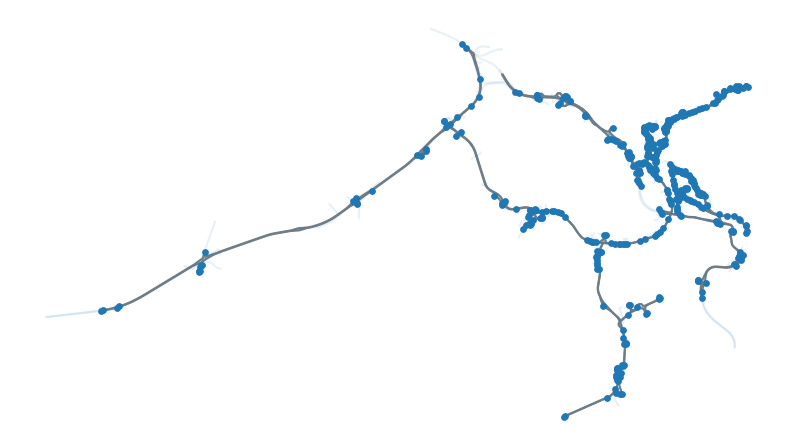

In [30]:
# visualize to check if all is correct
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
roads.iloc[roads.sindex.query(cluster_geom, predicate="intersects")].plot(
    ax=ax, alpha=0.1
)
artifacts[artifacts.comp == mycomp].plot(ax=ax, alpha=0.1, zorder=0)
edges_outside.plot(ax=ax, color="grey", zorder=1)
edges_within.plot(ax=ax, color="grey", alpha=0.1, zorder=2)
nodes_tokeep.plot(
    ax=ax, zorder=3, markersize=15
)
ax.set_axis_off()

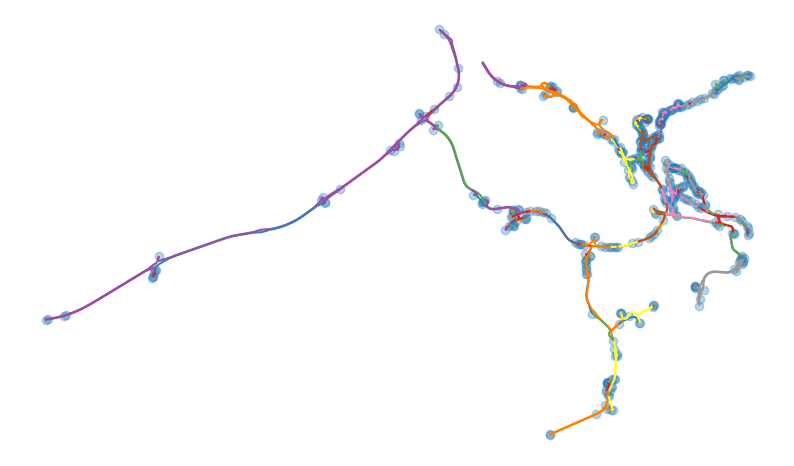

In [32]:
# merging lines between nodes to keep:
tiny_buffers = nodes_tokeep.buffer(eps).union_all()

# make queen contiguity graph on MINUSBUFFERED outline road segments,
# and copy component labels into edge_outside gdf
edges_outside = edges_outside.explode(ignore_index=True)
queen = graph.Graph.build_fuzzy_contiguity(edges_outside.difference(tiny_buffers))
edges_outside["comp"] = queen.component_labels

# plot to see if it worked
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
edges_outside.plot(column="comp", ax=ax, cmap="Set1")
nodes_tokeep.plot(ax=ax, alpha=0.3)
ax.set_axis_off()

In [33]:
%%time
skel, _ = voronoi_skeleton(  # this is the one we need
    edges_outside.dissolve(by="comp").geometry,
    cluster_geom,
    snap_to=False,
    #    buffer = 4
)

CPU times: user 11.6 s, sys: 376 ms, total: 11.9 s
Wall time: 12.1 s


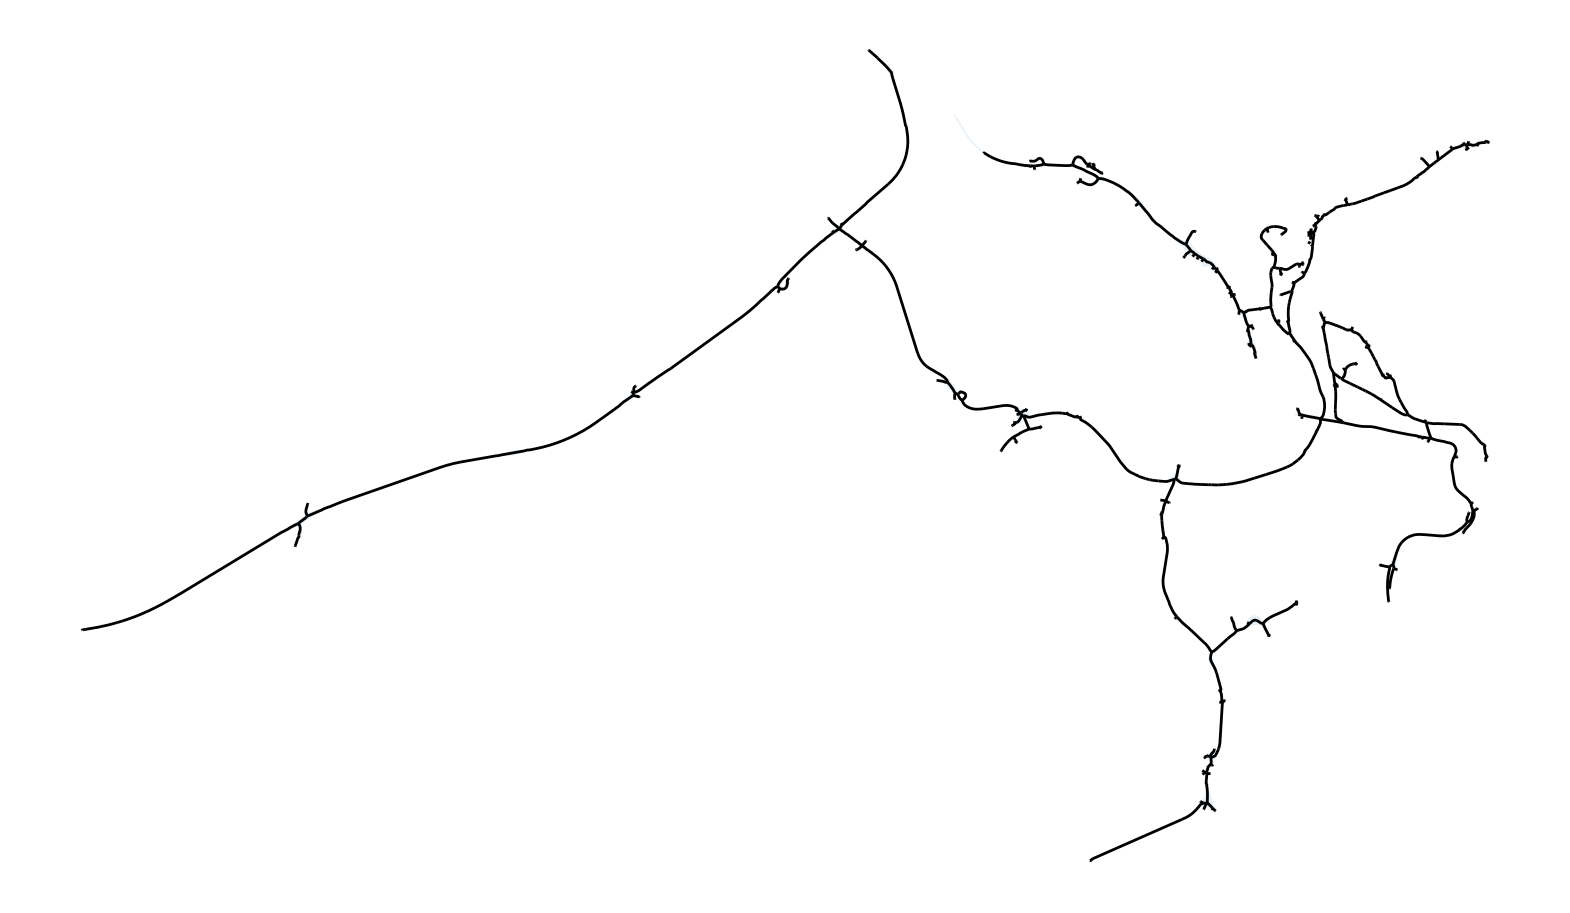

In [34]:
### plot to see if all is correct
fig, ax = plt.subplots(1, 1, figsize=(20, 40))

# plot the entire street network
# roads.iloc[roads.sindex.query(cluster_geom, predicate="intersects")].plot(ax=ax, alpha = .1)

# plot the artifact cluster
artifacts[artifacts.comp == mycomp].plot(ax=ax, alpha=0.1, zorder=0)

# plot artifact boundary
# edges_outside.plot(ax=ax, color = "blue", zorder = 1, alpha = .1, lw = 0.5)

# edges_within.plot(ax=ax, color = "grey", alpha = .1, zorder = 2)

# plot nodes to keep
# nodes_boundary[nodes_boundary.to_keep].plot(
#     ax=ax, zorder = 3, markersize = 10, color = "red"
# )

# plot skeletonization (=new edges WITHIN artifact cluster)
gpd.GeoSeries(skel).plot(ax=ax, color="black", lw=2)

# plot superfluous skeletonization (the above one is a subset of this)
# gpd.GeoSeries(skel_full).plot(ax=ax, color = "black", lw = 2, zorder = 0)

ax.set_axis_off()

In [45]:
m = gpd.GeoSeries([cluster_geom], crs = roads.crs).explore(name ="artifact", opacity=.1,     tiles="CartoDB.Positron",)
gpd.GeoSeries(skel, crs=roads.crs).explore(
    m=m,
    color="black",
    lw=2,
    name="skeleton"
)
nodes_tokeep.explore(m=m, name="nodes to keep", marker_kwds=dict(radius=5), color = "yellow")
roads.iloc[roads.sindex.query(cluster_geom, predicate="intersects")].explore(m=m, color = "red", highlight_kwds={"color":"green"}, opacity = .4, name = "roads")
folium.LayerControl().add_to(m)
m

# next step: figure out what to drop! 
Martin's suggestion - lines that are fully within the buffered cluster_geom